# Case Study: UQ models for RUL of Li-ion batteries
The notebook consists of the following parts
1) **Step 1: Loading/processing dataset**

2) **Step 2: Train the following UQ models**
- Deep Ensemble
- MC Dropout
- Gaussian Process Regression
- Spectral Normalization Gaussian Process

3) **Step 3: Postprocess UQ model results**

#### Note
This notebook is self sufficient. Some aspects of the code have large run time. We added flags to skip training and use saved results. The training flags can be toggled accordingly.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5' 
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as random
from progressbar import ProgressBar
from sklearn.preprocessing import MinMaxScaler
import scipy
import pickle

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, Reshape, Flatten, GlobalMaxPooling1D, Layer
from tensorflow.keras.layers import Dropout, ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError
from keras.initializers import glorot_normal
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from tensorflow.keras import Model
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse
import official.nlp.modeling.layers as nlp_layers

plt.rcParams.update({'font.size': 18})

## Step 1: Loading/processing dataset
### Load the Capacity data
- Three datasets: Train, Test1, Test2, Test3

In [2]:
number_cells = [41,42,40,45] # train and three tests
dataset = ['train', 'test1', 'test2', 'test3']

all_Q_curves = pd.DataFrame()
for myset in range(len(dataset)):
    for cell in range(number_cells[myset]):
        cell_Q = pd.read_csv("Dataset/discharge_capacity/"+dataset[myset]+"/cell"+str(cell+1)+".csv", 
                               header = None, names=['cycle_no', 'capacity', 'initial_capacity'])
        cell_Q['cell_no'] = cell+1 # cell number
        cell_Q['norm_Q'] = cell_Q['capacity']/cell_Q['initial_capacity'].iloc[0] # cell number
        cell_Q['dataset'] = dataset[myset]
        cell_Q['max_cycles'] = cell_Q.shape[0]
        all_Q_curves = pd.concat([all_Q_curves, cell_Q], axis=0)

### Plot the capacity curves

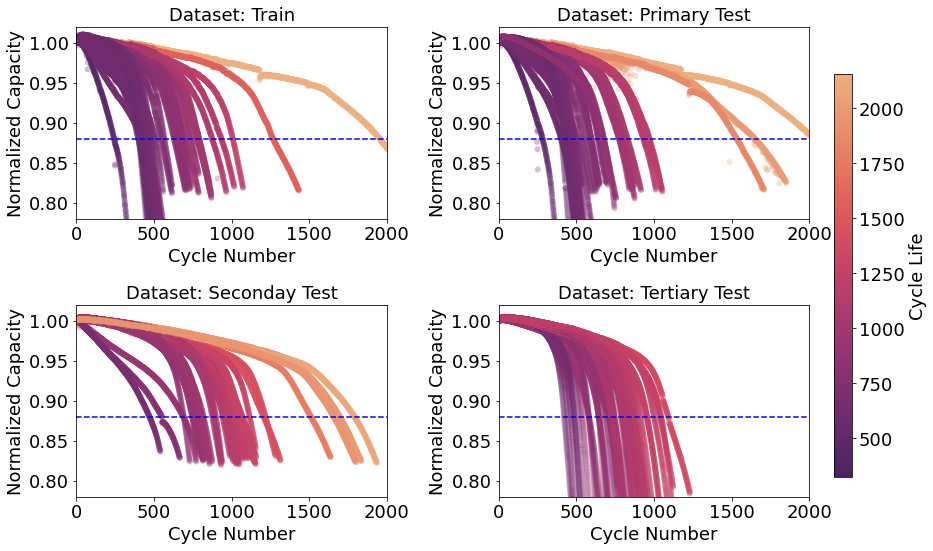

In [3]:
title_dict = {
  "train": "Train",
  "test1": "Primary Test",
  "test2": "Seconday Test",
  "test3": "Tertiary Test",  
}

fig, ax = plt.subplots(2,2,figsize=(12, 8))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    if dataset[myset] == 'train':
        legend_bool = True
    else:
        legend_bool = False
    sns.scatterplot(
        data=all_Q_curves.loc[all_Q_curves['dataset']==dataset[myset]], legend = False, ax = myax, 
        x="cycle_no", y="norm_Q", hue="max_cycles", palette="flare_r", 
        edgecolor="none", alpha = 0.3, hue_norm=(200,2000), rasterized = True
    )
    if legend_bool:
        norm = plt.Normalize(all_Q_curves.loc[all_Q_curves['dataset']==dataset[myset]]['max_cycles'].min(),
                             all_Q_curves.loc[all_Q_curves['dataset']==dataset[myset]]['max_cycles'].max())
        sm = plt.cm.ScalarMappable(cmap="flare_r", norm=norm)
        sm.set_array([])
        
    myax.axhline(0.88, linestyle='dashed', color = 'blue', label = 'cutoff')
    myax.set_title("Dataset: "+ title_dict[dataset[myset]], fontsize = 18)
    myax.set_xlabel("Cycle Number")
    myax.set_ylabel("Normalized Capacity")
    myax.set_xlim([0,2000])
    myax.set_ylim([0.78,1.02])
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.98, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Cycle Life', rotation=90)

    
plt.tight_layout()
fig.savefig("figs/capacity_curves.pdf", bbox_inches='tight')
fig.savefig("figs/capacity_curves.jpg", bbox_inches='tight')

### Load the VQ curve data

### We will use VQ(cycle=100)-VQ(cycle=10) as input feature(s) to determine RUL

In [4]:
number_cells = [41,42,40,45] # train and three tests
dataset = ['train', 'test1', 'test2', 'test3']

VQcol_names = ["cycle_"+str(i+1) for i in range(150)]
all_VQ_curves = pd.DataFrame()
for myset in range(len(dataset)):
    for cell in range(number_cells[myset]):
        cell_VQ = pd.read_csv("Dataset/V_Q_curve/"+dataset[myset]+"/cell"+str(cell+1)+".csv", header = None,
                               names=VQcol_names)
        cell_VQ['voltage'] = np.linspace(3.5,2,cell_VQ.shape[0])
        cell_VQ['diff_cycle100_cycle10'] = cell_VQ['cycle_100']-cell_VQ['cycle_10'] # input to models
        cell_VQ['cell_no'] = cell+1 # cell number
        cell_VQ['dataset'] = dataset[myset]
        all_VQ_curves = pd.concat([all_VQ_curves, cell_VQ], axis=0)

In [5]:
all_VQ_curves.head()

,cycle_1,cycle_2,cycle_3,cycle_4,cycle_5,cycle_6,cycle_7,cycle_8,cycle_9,cycle_10,...,cycle_145,cycle_146,cycle_147,cycle_148,cycle_149,cycle_150,voltage,diff_cycle100_cycle10,cell_no,dataset
0,-0.000460,-0.000352,-0.000451,-0.000230,-0.000168,-0.000447,-0.000328,-0.000361,-0.000158,-0.000167,...,-0.000295,-0.000340,-0.000292,-0.000329,-0.000307,NaN,3.500000,-0.000097,1,train
1,-0.000418,-0.000314,-0.000404,-0.000201,-0.000141,-0.000400,-0.000290,-0.000320,-0.000132,-0.000141,...,-0.000259,-0.000306,-0.000262,-0.000293,-0.000273,NaN,3.498498,-0.000092,1,train
2,-0.000378,-0.000278,-0.000360,-0.000172,-0.000114,-0.000356,-0.000254,-0.000282,-0.000106,-0.000115,...,-0.000225,-0.000272,-0.000232,-0.000259,-0.000240,NaN,3.496997,-0.000087,1,train
3,-0.000340,-0.000243,-0.000319,-0.000144,-0.000089,-0.000314,-0.000220,-0.000246,-0.000082,-0.000090,...,-0.000193,-0.000240,-0.000203,-0.000227,-0.000208,NaN,3.495495,-0.000082,1,train
4,-0.000303,-0.000211,-0.000281,-0.000116,-0.000064,-0.000275,-0.000188,-0.000212,-0.000059,-0.000066,...,-0.000163,-0.000209,-0.000174,-0.000196,-0.000178,NaN,3.493994,-0.000078,1,train


In [6]:
all_VQ_curves.groupby(by=['dataset', 'cell_no']).var().reset_index()

,dataset,cell_no,cycle_1,cycle_2,cycle_3,cycle_4,cycle_5,cycle_6,cycle_7,cycle_8,...,cycle_143,cycle_144,cycle_145,cycle_146,cycle_147,cycle_148,cycle_149,cycle_150,voltage,diff_cycle100_cycle10
0,test1,1,0.178752,0.179241,0.179079,0.179453,0.179358,0.179632,0.179590,0.179506,...,0.177868,0.177846,0.177759,0.177704,0.177670,0.177508,0.177683,NaN,0.188063,0.000009
1,test1,2,0.181725,0.182183,0.181989,0.182463,0.182225,0.182640,0.182494,0.182277,...,0.180655,0.180659,0.180621,0.180616,0.180548,0.180525,0.180546,NaN,0.188063,0.000011
2,test1,3,0.182167,0.182007,0.181987,0.182112,0.182336,0.182235,0.182355,0.182331,...,0.179545,0.179510,0.179463,0.179449,0.179423,0.179420,0.179379,NaN,0.188063,0.000025
3,test1,4,0.182607,0.182857,0.183438,0.183404,0.183316,0.183366,0.183376,0.183458,...,0.176391,0.176259,0.176179,0.176167,0.176036,0.176073,0.175996,NaN,0.188063,0.000169
4,test1,5,0.182917,0.183044,0.183438,0.183402,0.183329,0.183819,0.183975,0.183916,...,0.178252,0.178320,0.178365,0.178328,0.178260,0.178228,0.178179,NaN,0.188063,0.000105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,train,37,0.182196,0.182502,0.182961,0.182664,0.182682,0.183001,0.182762,0.182846,...,0.170665,0.170499,0.170139,0.170217,0.170072,0.169928,0.169949,NaN,0.188063,0.000308
164,train,38,0.183576,0.183577,0.184326,0.184238,0.184364,0.184615,0.184484,0.184521,...,0.170353,0.170470,0.170269,0.169122,0.170035,0.169658,0.169626,NaN,0.188063,0.000353
165,train,39,0.179789,0.179786,0.179393,0.180324,0.180193,0.179621,0.180416,0.180068,...,0.168280,0.168657,0.167971,0.167886,0.168248,0.167921,0.168274,NaN,0.188063,0.000207
166,train,40,0.182214,0.182752,0.182559,0.182490,0.182954,0.183030,0.183081,0.183180,...,0.167826,0.167731,0.167097,0.167074,0.167128,0.166798,0.166745,NaN,0.188063,0.000476


In [7]:
# load cycle lives
all_cycle_lives = pd.DataFrame()
for myset in range(len(dataset)):
    cycle_lives = pd.read_csv("Dataset/cycle_lives/"+dataset[myset]+"_cycle_lives.csv", header = None,
                             names=['cycle_life']).reset_index()
    cycle_lives['cell_no'] = cycle_lives['index'] + 1
    cycle_lives['dataset'] = dataset[myset]
    
    all_cycle_lives = pd.concat([all_cycle_lives, cycle_lives.drop('index', axis=1)], axis=0)

In [8]:
all_cycle_lives.head()

,cycle_life,cell_no,dataset
0,2160,1,train
1,1434,2,train
2,1074,3,train
3,870,4,train
4,788,5,train


In [9]:
# merge VQ curves and cycle lives
all_VQ_curves_merge = pd.merge(all_VQ_curves, all_cycle_lives, how='left',
                               left_on = ['dataset', 'cell_no'], right_on = ['dataset', 'cell_no'])
all_VQ_curves_merge_agg= all_VQ_curves_merge.groupby(by=['cell_no', 'dataset']).agg({'diff_cycle100_cycle10':'var',
                                                            'cycle_life': 'mean'}).reset_index()

In [10]:
all_VQ_curves_merge

,cycle_1,cycle_2,cycle_3,cycle_4,cycle_5,cycle_6,cycle_7,cycle_8,cycle_9,cycle_10,...,cycle_146,cycle_147,cycle_148,cycle_149,cycle_150,voltage,diff_cycle100_cycle10,cell_no,dataset,cycle_life
0,-0.000460,-0.000352,-0.000451,-0.000230,-0.000168,-0.000447,-0.000328,-0.000361,-0.000158,-0.000167,...,-0.000340,-0.000292,-0.000329,-0.000307,NaN,3.500000,-0.000097,1,train,2160
1,-0.000418,-0.000314,-0.000404,-0.000201,-0.000141,-0.000400,-0.000290,-0.000320,-0.000132,-0.000141,...,-0.000306,-0.000262,-0.000293,-0.000273,NaN,3.498498,-0.000092,1,train,2160
2,-0.000378,-0.000278,-0.000360,-0.000172,-0.000114,-0.000356,-0.000254,-0.000282,-0.000106,-0.000115,...,-0.000272,-0.000232,-0.000259,-0.000240,NaN,3.496997,-0.000087,1,train,2160
3,-0.000340,-0.000243,-0.000319,-0.000144,-0.000089,-0.000314,-0.000220,-0.000246,-0.000082,-0.000090,...,-0.000240,-0.000203,-0.000227,-0.000208,NaN,3.495495,-0.000082,1,train,2160
4,-0.000303,-0.000211,-0.000281,-0.000116,-0.000064,-0.000275,-0.000188,-0.000212,-0.000059,-0.000066,...,-0.000209,-0.000174,-0.000196,-0.000178,NaN,3.493994,-0.000078,1,train,2160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167995,1.028500,1.029300,1.030000,1.030300,1.030500,1.030800,1.030800,1.031000,1.031100,1.031000,...,1.027500,1.027200,1.027100,1.027100,NaN,2.006006,-0.000700,45,test3,943
167996,1.028600,1.029300,1.030000,1.030300,1.030500,1.030800,1.030800,1.031100,1.031100,1.031000,...,1.027500,1.027300,1.027100,1.027100,NaN,2.004505,-0.000600,45,test3,943
167997,1.028600,1.029300,1.030000,1.030300,1.030500,1.030800,1.030800,1.031100,1.031100,1.031000,...,1.027500,1.027300,1.027100,1.027100,NaN,2.003003,-0.000600,45,test3,943
167998,1.028600,1.029300,1.030000,1.030300,1.030600,1.030800,1.030800,1.031100,1.031100,1.031000,...,1.027600,1.027300,1.027200,1.027100,NaN,2.001502,-0.000600,45,test3,943


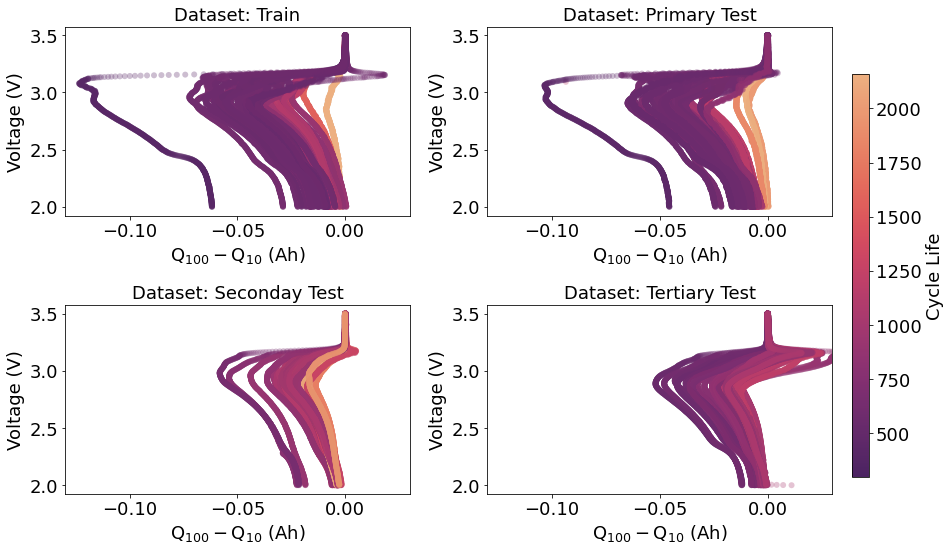

In [11]:
fig, ax = plt.subplots(2,2,figsize=(12, 8))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    if dataset[myset] == 'train':
        legend_bool = True
    else:
        legend_bool = False
    sns.scatterplot(
        data=all_VQ_curves_merge.loc[all_VQ_curves_merge['dataset']==dataset[myset]], ax = myax, legend = False,
        x="diff_cycle100_cycle10", y="voltage", hue="cycle_life", palette="flare_r", 
        edgecolor="none", alpha = 0.3, hue_norm=(200,2000), rasterized = True
    )
    if legend_bool:
#         myax.legend(title='Cycle life')
        norm = plt.Normalize(all_VQ_curves_merge.loc[all_VQ_curves_merge['dataset']==dataset[myset]
                                                ]['cycle_life'].min(),
                         all_VQ_curves_merge.loc[all_VQ_curves_merge['dataset']==dataset[myset]
                                                ]['cycle_life'].max())
        sm = plt.cm.ScalarMappable(cmap="flare_r", norm=norm)
        sm.set_array([])
    myax.set_title("Dataset: "+ title_dict[dataset[myset]], fontsize = 18)
    myax.set_xlabel("$ \mathrm{Q}_{100}-\mathrm{Q}_{10}$ (Ah)")
    myax.set_ylabel("Voltage (V)")
    myax.set_xlim([-0.13, 0.03])
    

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Cycle Life', rotation=90)
plt.tight_layout()
fig.savefig("figs/VQ_curves.pdf", bbox_inches='tight')
fig.savefig("figs/VQ_curves.jpg", bbox_inches='tight')

### Data Visualization
(similar to the Nature Energy paper)

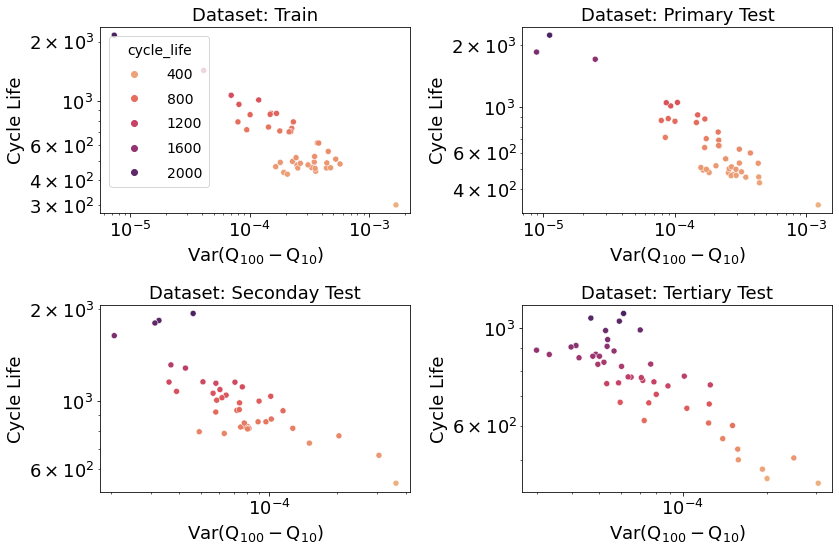

In [12]:
fig, ax = plt.subplots(2,2,figsize=(12, 8))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    if dataset[myset] == 'train':
        legend_bool = True
    else:
        legend_bool = False
        
    myplt = sns.scatterplot(
        data=all_VQ_curves_merge_agg.loc[all_VQ_curves_merge_agg['dataset']==dataset[myset]], legend = legend_bool,
        x="diff_cycle100_cycle10", y="cycle_life", hue="cycle_life", palette="flare", ax = myax, rasterized = True
    )
    myax.set_title("Dataset: "+ title_dict[dataset[myset]], fontsize = 18)
    myax.set_xlabel("Var($ \mathrm{Q}_{100}-\mathrm{Q}_{10}$)")
    myax.set_ylabel("Cycle Life")
    myax.set_xscale('log')
    myax.set_yscale('log')
    if legend_bool:
        plt.setp(myplt.get_legend().get_texts(), fontsize='14') # for legend text
        plt.setp(myplt.get_legend().get_title(), fontsize='14') # for legend title

plt.tight_layout()
fig.savefig("figs/VQ_correlation.jpg")
fig.savefig("figs/VQ_correlation.pdf")

In [13]:
all_VQ_curves_merge.head()

,cycle_1,cycle_2,cycle_3,cycle_4,cycle_5,cycle_6,cycle_7,cycle_8,cycle_9,cycle_10,...,cycle_146,cycle_147,cycle_148,cycle_149,cycle_150,voltage,diff_cycle100_cycle10,cell_no,dataset,cycle_life
0,-0.000460,-0.000352,-0.000451,-0.000230,-0.000168,-0.000447,-0.000328,-0.000361,-0.000158,-0.000167,...,-0.000340,-0.000292,-0.000329,-0.000307,NaN,3.500000,-0.000097,1,train,2160
1,-0.000418,-0.000314,-0.000404,-0.000201,-0.000141,-0.000400,-0.000290,-0.000320,-0.000132,-0.000141,...,-0.000306,-0.000262,-0.000293,-0.000273,NaN,3.498498,-0.000092,1,train,2160
2,-0.000378,-0.000278,-0.000360,-0.000172,-0.000114,-0.000356,-0.000254,-0.000282,-0.000106,-0.000115,...,-0.000272,-0.000232,-0.000259,-0.000240,NaN,3.496997,-0.000087,1,train,2160
3,-0.000340,-0.000243,-0.000319,-0.000144,-0.000089,-0.000314,-0.000220,-0.000246,-0.000082,-0.000090,...,-0.000240,-0.000203,-0.000227,-0.000208,NaN,3.495495,-0.000082,1,train,2160
4,-0.000303,-0.000211,-0.000281,-0.000116,-0.000064,-0.000275,-0.000188,-0.000212,-0.000059,-0.000066,...,-0.000209,-0.000174,-0.000196,-0.000178,NaN,3.493994,-0.000078,1,train,2160


### Make Input-Output for training the UQ models
Input:- VQ(100)-VQ(10)

Output:- cycle life

In [14]:
def get_input_output(df, myset):
    """
    inputs:
    df    - dataframe with inputs and outputs
    myset - set as 'train', 'test1'...'test3'
    outputs:
    X, Y for training the models
    """
    df_myset = df.loc[df['dataset']==myset]
    X, Y = [], []
    for mycell in sorted(set(df_myset['cell_no'])):
        X.append(df_myset.loc[df_myset['cell_no']==mycell].sort_values(
            by='voltage', ascending = False, axis = 0)['diff_cycle100_cycle10'].values)
        Y.append(df_myset.loc[df_myset['cell_no']==mycell]['cycle_life'].mean())
    return X, np.expand_dims(Y, axis=1)

In [15]:
Xtrain, Ytrain = get_input_output(all_VQ_curves_merge, 'train')
Xtest1, Ytest1 = get_input_output(all_VQ_curves_merge, 'test1')
Xtest2, Ytest2 = get_input_output(all_VQ_curves_merge, 'test2')
Xtest3, Ytest3 = get_input_output(all_VQ_curves_merge, 'test3')

scalerX = MinMaxScaler()
Xtrain_norm, Ytrain_norm  = scalerX.fit_transform(Xtrain), (Ytrain)/np.max(Ytrain)
Xtest1_norm, Ytest1_norm  = scalerX.transform(Xtest1), (Ytest1)/np.max(Ytrain)
Xtest2_norm, Ytest2_norm  = scalerX.transform(Xtest2), (Ytest2)/np.max(Ytrain)
Xtest3_norm, Ytest3_norm  = scalerX.transform(Xtest3), (Ytest3)/np.max(Ytrain)

### Common functions definitions

In [16]:
# Ensembling of individual models
def get_ensemble(pred_df, UQmodelcode, nmodels_select):
    """
    Input
    pred_df - dataframe with individual model predictions
              Columns named as "NN_mu_#ofmodel" and "NN_sigma_#ofmodel"
    UQmodelcode - 'NN' for neural network ensemble, 'MC' for MC dropout
    nmodels_select - number of individual models to form the ensemble
    """
    mu_cols = [UQmodelcode + "_mu_"+str(i) for i in range(nmodels_select)]
    sigma_cols = [UQmodelcode + "_sigma_"+str(i) for i in range(nmodels_select)]
    
    mu_eff = pred_df[mu_cols].mean(axis=1)
    if UQmodelcode=="NN":
        sigma_eff =  np.sqrt(np.mean(pred_df[mu_cols]**2, axis = 1)
                             + np.mean(pred_df[sigma_cols]**2, axis = 1)
                             - mu_eff**2)
    elif UQmodelcode=="MC": # no sigma_cols for individual models
        sigma_eff =  np.sqrt(np.mean(pred_df[mu_cols]**2, axis = 1)
                             - mu_eff**2)
    pred_df[UQmodelcode+"_mu_eff"] = mu_eff
    pred_df[UQmodelcode+"_sigma_eff"] = sigma_eff
    return pred_df
    
# Get calibration curves
def get_confidence_interval(y_true, mu, sigma):
    """
    Input: 
    y_true - true values
    mu     - predicted mean
    sigma  - predicted standard deviation
    
    Output:
    exp_CIs - expected confidence
    pred_CIs - predicted confidence
    """
    exp_CIs = np.linspace(1e-10, 1-1e-10, 1000) #expected CIs
    pred_CIs=[]                                 #predicted CIs
    for exp_CI in sorted(exp_CIs):
        intervals = scipy.stats.norm.interval(exp_CI, loc=mu, scale=sigma)
        lower_bd = intervals[0]
        upper_bd = intervals[1]
        pred_CIs.append(np.sum((y_true > lower_bd) & (y_true < upper_bd))/len(y_true))
    
    ECE = np.mean(np.abs(exp_CIs - pred_CIs))
    return 100*exp_CIs, 100*np.array(pred_CIs), 100*ECE  # converting to percentages

def get_rmse(y_true, y_pred):
    """
    Inputs:
    y_true - true values
    y_pred - predicted values
    Outputs:
    root mean squarred error
    """
    return np.sqrt(np.mean((y_true-y_pred)**2))

def get_nll(y_true, y_pred, s_pred):
    """
    Inputs:
    y_true - true values
    y_pred - predicted values
    s_pred - predicted standard deviation
    Outputs:
    median of NLL
    """
    return np.mean(np.log(s_pred**2)/2 + 
                     np.divide((y_true - y_pred)**2, 2* s_pred**2))

## Step 2: UQ model training

Each of the model has the following sequence:
- model functions/class definitions
- a single end-to-end run
- multiple independent runs to capture run-to-run variations

### Uncertainty Model 1: Neural Network Ensemble (NN)

- Use of Gaussian Layer that outputs - mean and aleatoric variance
- Use of Negative Log Likelihood loss (NLL)
- Ensemble to capture epistematic uncertainty

In [17]:
# loss function and new custom layer to give mean and standard deviation
# Inspired from https://medium.com/@albertoarrigoni/paper-review-code-deep-ensembles-nips-2017-c5859070b8ce
def custom_loss(variance):
    def nll_loss(y_true, y_pred):
        return tf.reduce_mean(0.5*tf.math.log((variance)) + 
                              0.5*tf.math.divide(tf.math.square(y_true - y_pred), variance)) + 1e-6
    return nll_loss
class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='kernel_1', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(GaussianLayer, self).build(input_shape) 
    def call(self, x):
        output_mu  = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06  
        return [output_mu, output_sig_pos]
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]

In [18]:
def generate_trained_NNmodel(trainX, trainY, nepochs, actfn = 'relu'):
    """
    Inputs:
    trainX  - training input of shape (samples, num of features)
    trainY  - training output of shape (samples, 1)
    nepochs - number of epochs
    actfn   - activation function
    Outputs:
    get_gl_function - Gaussian layer outputs as function 
    """
    num_res_layers = 2
    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(100, activation = actfn)(feature_input)
    for _ in range(num_res_layers):
        x  = Dense(50, activation = actfn)(x)
        x1 = Dense(50, activation = actfn)(x)
        x = x1 + x
    x = Dense(10, activation = actfn)(x)
      
    mu, variance = GaussianLayer(1, name='main_output')(x)
    model = Model(feature_input, mu)
    model.compile(loss=custom_loss(variance), optimizer='adam')
    model.fit(trainX, trainY,shuffle=True, epochs=nepochs, verbose = 0)
    
    layer_name = 'main_output' # Where to extract the Gaussian output from. 
    get_gl_function = K.function(inputs=[model.input], 
                                  outputs=model.get_layer(layer_name).output)
    return get_gl_function

### Single Run
- Multiple models are trained and the best model(s) are selected based on training error.
- Ensemble the individual selected models

(We later perform elbow method to determine the ensemble size)

In [19]:
# First let us do a single run
prediction_fns, train_rmse = [], []
nmodels = 10       # Create 10 models and select some based on training error

pbar=ProgressBar()
for i in pbar(range(nmodels)):
    my_func = generate_trained_NNmodel(Xtrain_norm, Ytrain_norm, nepochs = 6000, actfn = 'relu')
    train_rmse.append(get_rmse(Ytrain, (my_func(Xtrain_norm)[0])*np.max(Ytrain)))
    prediction_fns.append(my_func)
    
nmodels_select = 5  # select these # of models
final_NN_fns = []
for i in range(nmodels_select):
    final_NN_fns.append(prediction_fns[np.argsort(train_rmse)[:nmodels_select][i]])

100% |#########################################################################|


In [20]:
# Evaluate on all datasets
allresults_df = pd.DataFrame()
for myset in dataset:
    exec("Xnorm =X"+myset+"_norm")
    exec("Y =Y"+myset)

    result_df = pd.DataFrame(Y, columns = ['True'])
    result_df['dataset'] = myset
    for i in range(nmodels_select):
        result_df["NN_mu_"+str(i)] = (final_NN_fns[i](Xnorm)[0])*np.max(Ytrain)
        result_df["NN_sigma_"+str(i)] = (np.sqrt(final_NN_fns[i](Xnorm)[1]))*np.max(Ytrain)

    result_df = get_ensemble(result_df, "NN", nmodels_select)
    allresults_df = pd.concat([allresults_df, result_df], axis = 0)
allresults_df.head()

,True,dataset,NN_mu_0,NN_sigma_0,NN_mu_1,NN_sigma_1,NN_mu_2,NN_sigma_2,NN_mu_3,NN_sigma_3,NN_mu_4,NN_sigma_4,NN_mu_eff,NN_sigma_eff
0,2160.0,train,2130.620361,119.009727,2079.622803,307.456177,2075.839844,82.563766,2203.375488,107.539131,2062.002441,206.519699,2110.292236,191.447113
1,1434.0,train,1475.569824,84.429420,1452.009033,197.758698,1390.546143,119.598740,1525.135986,146.844635,1387.812622,210.342178,1446.214600,167.321915
2,1074.0,train,1051.187622,65.486336,971.918213,80.104454,883.745422,112.379532,1017.964905,96.486626,839.119690,115.904793,952.787231,124.948990
3,870.0,train,838.327759,48.377235,842.796265,59.670113,787.646301,61.797970,833.810181,65.221657,786.290771,91.312447,817.774292,71.436600
4,788.0,train,850.919373,54.256847,901.428223,68.244415,938.716858,127.913322,1023.620544,106.585121,918.574036,163.350281,926.651855,124.892952


In [21]:
print("Train RMSE: ", get_rmse(allresults_df.loc[allresults_df['dataset']=='train']['True'],
                               allresults_df.loc[allresults_df['dataset']=='train']['NN_mu_eff']))
print("Test1 RMSE: ", get_rmse(allresults_df.loc[allresults_df['dataset']=='test1']['True'],
                               allresults_df.loc[allresults_df['dataset']=='test1']['NN_mu_eff']))
print("Test2 RMSE: ", get_rmse(allresults_df.loc[allresults_df['dataset']=='test2']['True'],
                               allresults_df.loc[allresults_df['dataset']=='test2']['NN_mu_eff']))
print("Test3 RMSE: ", get_rmse(allresults_df.loc[allresults_df['dataset']=='test3']['True'],
                               allresults_df.loc[allresults_df['dataset']=='test3']['NN_mu_eff']))

Train RMSE:  39.4809725522275
Test1 RMSE:  113.36544568077494
Test2 RMSE:  224.45186509981372
Test3 RMSE:  122.74462104788914


### Single Run: Results/Visualization

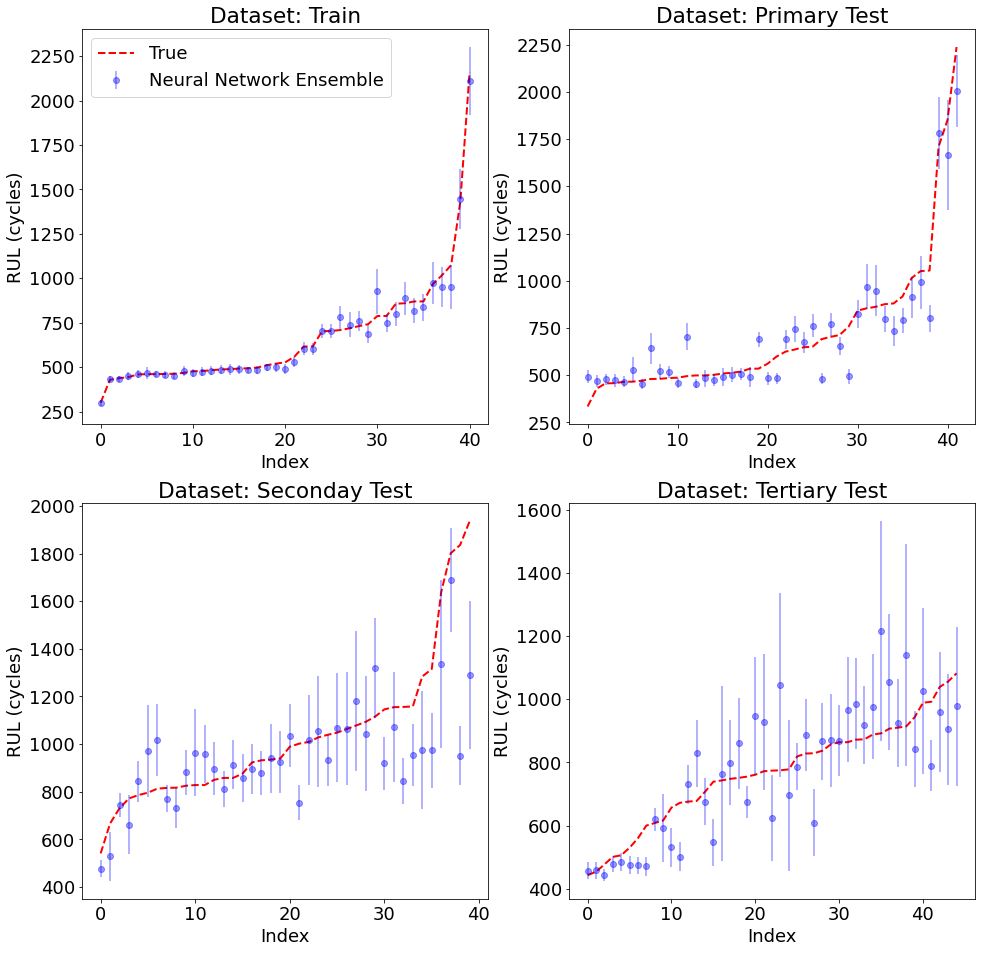

In [22]:
allresults_df_sorted = allresults_df.sort_values(by='True', ascending=True)
fig, ax = plt.subplots(2,2,figsize=(16, 16))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    df = allresults_df_sorted.loc[allresults_df_sorted['dataset']==dataset[myset]]
    myax.plot(range(df.shape[0]), df['True'], 
             color='red', linestyle='dashed', linewidth=2, label='True')
    myax.errorbar(range(df.shape[0]), df['NN_mu_eff'], 
                 yerr = df['NN_sigma_eff'],
                 fmt='o', color='blue', alpha = 0.4, label='Neural Network Ensemble')
    myax.set_title("Dataset: "+ title_dict[dataset[myset]])
    myax.set_xlabel("Index")
    myax.set_ylabel("RUL (cycles)")
    if myset ==0:
        myax.legend()

In [23]:
allresults_df_sorted.head()

,True,dataset,NN_mu_0,NN_sigma_0,NN_mu_1,NN_sigma_1,NN_mu_2,NN_sigma_2,NN_mu_3,NN_sigma_3,NN_mu_4,NN_sigma_4,NN_mu_eff,NN_sigma_eff
20,300.0,train,300.050873,23.657366,286.959473,17.059914,294.511261,11.174216,308.149323,9.094401,298.824249,20.124647,297.699036,18.464916
21,335.0,test1,482.059143,10.463971,539.658081,32.781067,461.421906,10.488556,472.081512,4.331163,507.232788,10.916210,492.490723,32.755486
38,429.0,train,437.179047,21.258366,418.927246,13.992750,431.458221,9.949914,430.311401,8.975487,442.488068,20.121004,432.072815,17.565947
40,429.0,test1,467.263885,23.789194,475.455231,25.566408,442.086060,10.665530,514.993530,6.166103,442.638336,20.543705,468.487396,32.776707
21,438.0,train,429.515320,23.557154,426.097870,15.448645,431.163635,9.906076,439.706207,9.334740,442.402985,20.194656,433.777191,17.778147


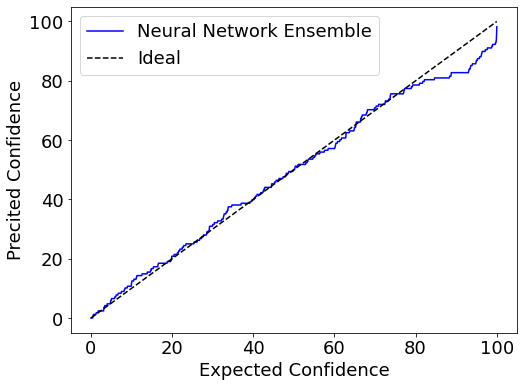

In [24]:
exp_CI, CI_NN, ECE_NN = get_confidence_interval(allresults_df_sorted['True'].values, 
                                       allresults_df_sorted['NN_mu_eff'].values, 
                                       allresults_df_sorted['NN_sigma_eff'].values)

fig = plt.figure(figsize=(8,6))
plt.plot(exp_CI,CI_NN, color = 'blue', label='Neural Network Ensemble')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()

### Elbow method to determine ensemble size

- Vary the ensemble size from 2 to 30
- iterate each selection of ensemble size for 15 times to capture run-to-run variation

This requires training enormous number of models. We therefore train a pool of 80 models and randomly pick models from this pool. 

toggle `elbow_trail_bool` to skip training and use saved results

In [25]:
elbow_trail_bool=False

if elbow_trail_bool:
    # First let us do a single run
    # Create 80 models and select 60 based on training error
    prediction_fns, train_rmse = [], []
    nmodels = 80  # train a total of these individual models
    nepochs = 8000

    pbar=ProgressBar()
    for i in pbar(range(nmodels)):
        my_func = generate_trained_NNmodel(Xtrain_norm, Ytrain_norm, nepochs, actfn = 'relu')
        train_rmse.append(get_rmse(Ytrain, (my_func(Xtrain_norm)[0])*np.max(Ytrain)))
        prediction_fns.append(my_func)

    nmodels_select = 60 # select these models based on training RMSE
    final_NN_fns = []
    for i in range(nmodels_select):
        final_NN_fns.append(prediction_fns[np.argsort(train_rmse)[:nmodels_select][i]])

In [26]:
max_ensemble = 30    # max ensemble size 
max_iterations = 15  # several iterations for models selection within the model pool for each ensemble size

if elbow_trail_bool:
    global_rmse_NN = np.zeros((max_iterations,max_ensemble))
    global_ece_NN  = np.zeros((max_iterations,max_ensemble))
    for iteration in range(max_iterations):
        for nensemble in range(1,max_ensemble+1):
            result_df = pd.DataFrame(Ytrain, columns = ['True'])
            count = 0 # indexing variable
            for model_no in random.sample(list(np.arange(nmodels_select)),nensemble):
                # randomly select nensemble number of models from the pool
                result_df["NN_mu_"+str(count)] = (final_NN_fns[model_no](Xtrain_norm)[0])*np.max(Ytrain)
                result_df["NN_sigma_"+str(count)] = (np.sqrt(final_NN_fns[model_no](Xtrain_norm)[1])
                                                     )*np.max(Ytrain)
                count = count+1

            result_df = get_ensemble(result_df, "NN", nensemble)

            # calculate the RMSE and ECE
            global_rmse_NN[iteration, nensemble-1]=get_rmse(result_df['True'], result_df['NN_mu_eff'])
            exp_CI, CI_NN, global_ece_NN[iteration, nensemble-1]=get_confidence_interval(result_df['True'].values, 
                                           result_df['NN_mu_eff'].values, 
                                           result_df['NN_sigma_eff'].values)
    with open('NN_elbow.pkl', 'wb') as f: 
        pickle.dump([global_rmse_NN, global_ece_NN], f)

else:
    with open('NN_elbow.pkl', 'rb') as f: 
        global_rmse_NN, global_ece_NN = pickle.load(f)

Text(0, 0.5, 'ECE (%)')

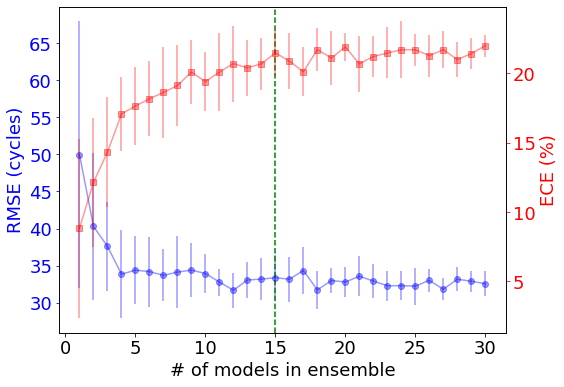

In [27]:
fig, ax = plt.subplots(1,1,figsize=(8, 6))
myax=ax
myax.errorbar(range(1,max_ensemble+1), np.mean(global_rmse_NN, axis = 0), 
                 yerr = np.std(global_rmse_NN, axis = 0), linestyle='-',
                 fmt='o', color='blue', alpha = 0.4, label='RMSE')
myax.axvline(15, linestyle='--',color = 'green', linewidth = 1.5)
myax.set_xlabel('# of models in ensemble')
myax.set_ylabel('RMSE (cycles)')
myax.yaxis.label.set_color('blue')
myax.tick_params(axis='y', colors='blue')

myax=ax.twinx()
myax.errorbar(range(1,max_ensemble+1), np.mean(global_ece_NN, axis = 0), 
                 yerr = np.std(global_ece_NN, axis = 0), linestyle='-',
                 fmt='s', color='red', alpha = 0.4, label='ECE')
myax.yaxis.label.set_color('red')
myax.tick_params(axis='y', colors='red')
myax.set_ylabel('ECE (%)')
# fig.savefig("figs/elbow_ensemble.jpg")

### Repeat the above algorithm for 10 times to capture run-to-run variations

toggle `model_train_bool` to skip training and use saved results

In [28]:
model_train_bool = False

if model_train_bool:
    niter = 10 # Multiple runs
    nepochs = 8000
    nmodels = 20 # train models for each iteration
    nmodels_select = 15 # select top models based on training rmse

    allCI_NN = np.zeros((1000, niter))
    pbar=ProgressBar()

    allresults_NNdf = pd.DataFrame()
    for myiter in pbar(range(niter)):
        prediction_fns=[]
        train_rmse=[]
        for i in range(nmodels):
            my_func = generate_trained_NNmodel(Xtrain_norm, Ytrain_norm, nepochs, actfn = 'tanh')
            train_rmse.append(mae(Ytrain, (my_func(Xtrain_norm)[0])*np.max(Ytrain)))
            prediction_fns.append(my_func)

        
        final_NN_fns = []
        for i in range(nmodels_select):
            final_NN_fns.append(prediction_fns[np.argsort(train_rmse)[:nmodels_select][i]])


        for myset in dataset:
            exec("Xnorm =X"+myset+"_norm")
            exec("Y =Y"+myset)

            result_df = pd.DataFrame(Y, columns = ['True'])
            result_df['dataset'] = myset
            for i in range(nmodels_select):
                result_df["NN_mu_"+str(i)] = (final_NN_fns[i](Xnorm)[0])*np.max(Ytrain)
                result_df["NN_sigma_"+str(i)] = (np.sqrt(final_NN_fns[i](Xnorm)[1]))*np.max(Ytrain)

            result_df = get_ensemble(result_df, "NN", nmodels_select)
            result_df['iteration'] = myiter
            allresults_NNdf = pd.concat([allresults_NNdf, result_df], axis = 0)
    allresults_NNdf.to_excel("NNEnsemble_battery_prediction_results.xlsx")  
else:
    allresults_NNdf=pd.read_excel("NNEnsemble_battery_prediction_results.xlsx")  

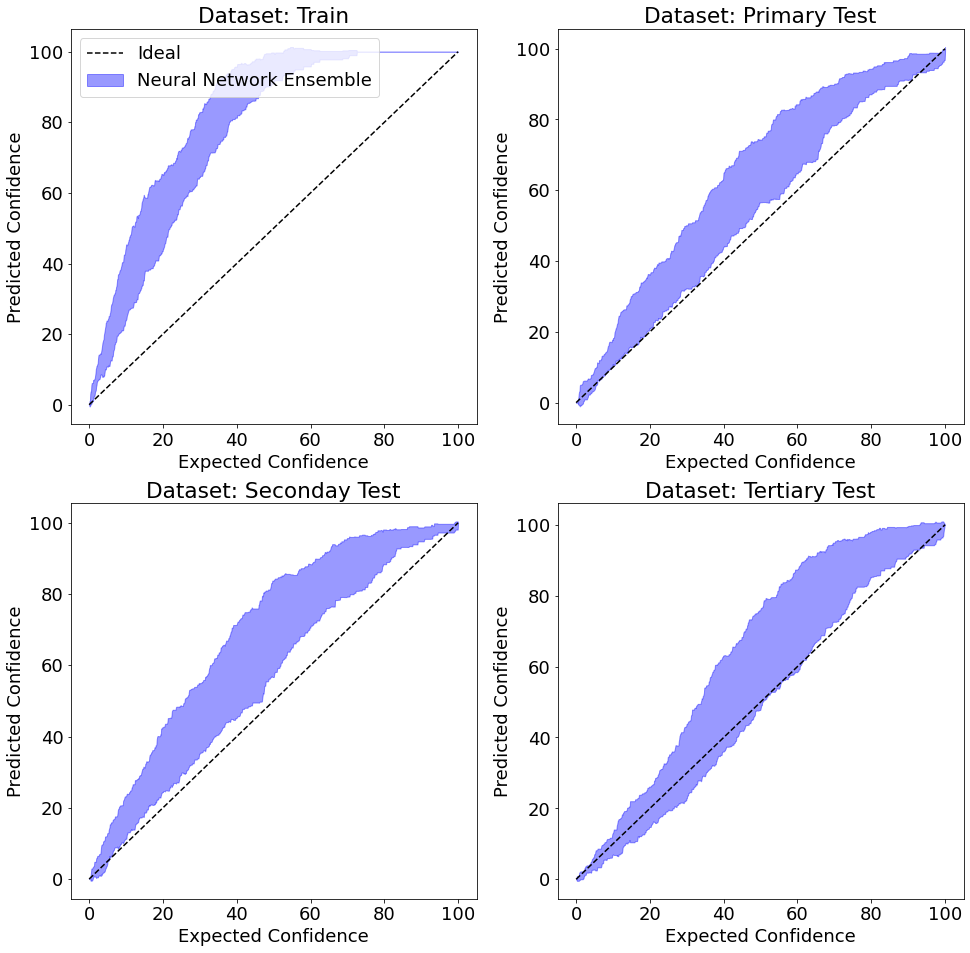

In [29]:
# plot calibration curve
niter = len(set(allresults_NNdf['iteration']))
fig, ax = plt.subplots(2,2,figsize=(16, 16))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    
    allCI_NN = np.zeros((1000, niter))
    for myiter in range(niter):
        df = allresults_NNdf.loc[(allresults_NNdf['dataset']==dataset[myset]) & 
                                 (allresults_NNdf['iteration']==myiter)]
        exp_CI, CI_NN, ECE  = get_confidence_interval(df['True'].values, 
                                               df['NN_mu_eff'].values, 
                                               df['NN_sigma_eff'].values)
        allCI_NN[:,myiter] = CI_NN
        
    myax.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
    myax.fill_between(exp_CI,
                np.mean(allCI_NN, axis = 1)+np.std(allCI_NN, axis = 1),
                np.mean(allCI_NN, axis = 1)-np.std(allCI_NN, axis = 1),
                color='blue', alpha = 0.4, linestyle='None', label='Neural Network Ensemble')


    myax.set_title("Dataset: "+ title_dict[dataset[myset]])
    myax.set_xlabel("Expected Confidence")
    myax.set_ylabel("Predicted Confidence")
    if myset ==0:
        myax.legend()

## Uncertainty Model 2: MC Dropout (MC)

- Simple Resnet with 10% dropout probability

In [30]:
def generate_trained_MCmodel(trainX, trainY, nepochs, actfn = 'relu'):
    """
    Inputs:
    trainX  - training input of shape (samples, num of features)
    trainY  - training output of shape (samples, 1)
    nepochs - number of epochs
    actfn   - activation function
    Outputs:
    model - MC Dropout model 
    """
    num_res_layers = 2
    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(100, activation = actfn)(feature_input)
    x = Dropout(rate = 0.10)(x)
    for _ in range(num_res_layers):
        x  = Dense(50, activation = actfn)(x)
        x1 = Dense(50, activation = actfn)(x)
        x = x1 + x
        x = Dropout(rate = 0.10)(x)
    mu = Dense(1, activation = actfn)(x)
    optimizer = Adam(learning_rate = 0.0004)
    model = Model(feature_input, mu)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(trainX, trainY,shuffle=True, epochs=nepochs, verbose = 0)

    return model

### Single Run

- Train 5 models and select the best based on training error

In [31]:
nmodels = 5 # train models and select the best out of these
all_models_MC=[]
all_rmse_train_MC = np.zeros(nmodels,)
pbar = ProgressBar()
for i in pbar(range(nmodels)):
    model_MC = generate_trained_MCmodel(Xtrain_norm, Ytrain_norm, 6000, 'relu')
    all_rmse_train_MC[i] = get_rmse(K.get_value(model_MC(Xtrain_norm))*(np.max(Ytrain)), Ytrain)
    all_models_MC.append(model_MC)
    
select_modelMC = all_models_MC[np.argmin(all_rmse_train_MC)]
print("Train RMSE: ", get_rmse(K.get_value(select_modelMC(Xtrain_norm))*(np.max(Ytrain)), Ytrain))
print("Test1 RMSE: ", get_rmse(K.get_value(select_modelMC(Xtest1_norm))*(np.max(Ytrain)), Ytest1))
print("Test2 RMSE: ", get_rmse(K.get_value(select_modelMC(Xtest2_norm))*(np.max(Ytrain)), Ytest2))
print("Test3 RMSE: ", get_rmse(K.get_value(select_modelMC(Xtest3_norm))*(np.max(Ytrain)), Ytest3))

100% |#########################################################################|


Train RMSE:  103.31145708198275
Test1 RMSE:  193.74743075114904
Test2 RMSE:  263.4458406586787
Test3 RMSE:  115.57891824807791


In [32]:
# Obtain the RUL prediction results for multiple runs
nensemble_size = 15 # we will later find the right ensemble size
allresults_MCdf = pd.DataFrame()
for myset in dataset: # train, test1, test2, test3
    exec("Xnorm =X"+myset+"_norm") # get onput
    exec("Y =Y"+myset)             # get true output

    result_df = pd.DataFrame(Y, columns = ['True'])
    result_df['dataset'] = myset
    for i in range(nensemble_size):
        result_df["MC_mu_"+str(i)] = K.get_value(select_modelMC(Xnorm, training=True))*(np.max(Ytrain))
        # training = True -> active dropout
        # select_modelMC -> trained MC Dropout model
        # (np.max(Ytrain)) -> scale back the predictions

    allresults_MCdf = pd.concat([allresults_MCdf, result_df], axis = 0)
allresults_MCdf = get_ensemble(allresults_MCdf, "MC", nensemble_size)

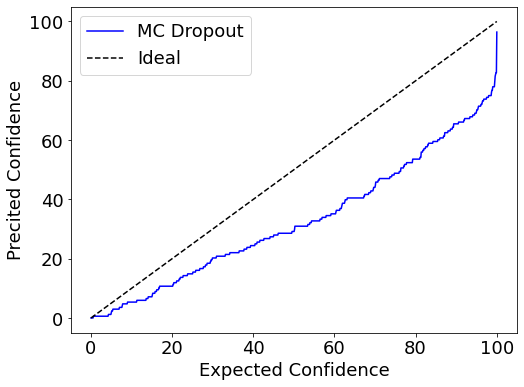

In [33]:
# plot the calibration curve
exp_CI, CI_MC, ECE = get_confidence_interval(allresults_MCdf['True'].values, 
                                       allresults_MCdf['MC_mu_eff'].values, 
                                       allresults_MCdf['MC_sigma_eff'].values)
fig = plt.figure(figsize=(8,6))
plt.plot(exp_CI,CI_MC, color = 'blue', label='MC Dropout')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()

### Elbow method to determine ensemble size

- Vary the ensemble size from 2 to 30
- iterate each selection of ensemble size for 15 times to capture run-to-run variation

toggle `elbow_train_bool` to skip training and use saved results

In [34]:
elbow_train_bool = False

max_ensemble = 30    # max ensemble size 
max_iterations = 15  # several iterations for models selection within the model pool for each ensemble size
nmodels = 3          # train models and select the best out of these

if elbow_train_bool:
    global_rmse_MC = np.zeros((max_iterations,max_ensemble))
    global_ece_MC = np.zeros((max_iterations,max_ensemble))
    pbar=ProgressBar()
    for iteration in pbar(range(max_iterations)):
        all_result_df = pd.DataFrame(Ytrain, columns = ['True'])
        # train
        all_models_MC=[]
        all_rmse_train_MC = np.zeros(nmodels,)
        for i in range(nmodels):
            model_MC = generate_trained_MCmodel(Xtrain_norm, Ytrain_norm, 10000, 'relu')
            all_rmse_train_MC[i] = get_rmse(K.get_value(model_MC(Xtrain_norm))*(np.max(Ytrain)), 
                                            Ytrain)
            all_models_MC.append(model_MC)    

        #select the least training error model and run repeatedly for max_ensemble
        select_modelMC = all_models_MC[np.argmin(all_rmse_train_MC)]
        for model_no in range(max_ensemble):
            all_result_df["MC_mu_"+str(model_no)] = K.get_value(select_modelMC(Xtrain_norm, training=True)
                                                               )*(np.max(Ytrain))

        # vary the ensemble size - select from the pool of "all_result_df"
        for nensemble in range(1,max_ensemble+1):
            mu_cols_select = ["MC_mu_"+str(i) for i in random.sample(list(np.arange(max_ensemble)),nensemble)]
            mu_cols_rename = ["MC_mu_"+str(i) for i in range(nensemble)]
            result_df = all_result_df[mu_cols_select].copy()
            result_df.columns = mu_cols_rename
            result_df['True'] = Ytrain
            result_df = get_ensemble(result_df, "MC", nensemble)
            global_rmse_MC[iteration, nensemble-1]=get_rmse(result_df['True'], result_df['MC_mu_eff'])
            exp_CI, CI_MC, global_ece_MC[iteration, nensemble-1] = get_confidence_interval(result_df['True'].values, 
                                           result_df['MC_mu_eff'].values, 
                                           result_df['MC_sigma_eff'].values)
        
    with open('MC_elbow.pkl', 'wb') as f: 
        pickle.dump([global_rmse_MC, global_ece_MC], f)

else:
    with open('MC_elbow.pkl', 'rb') as f: 
        global_rmse_MC, global_ece_MC = pickle.load(f)

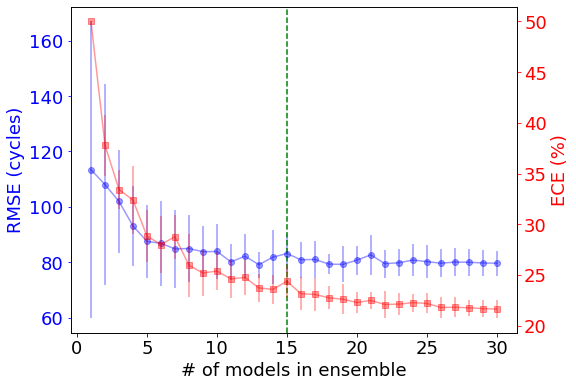

In [35]:
# plot variation with ensemble size
fig, ax = plt.subplots(1,1,figsize=(8, 6))
myax = ax
myax.errorbar(range(1,max_ensemble+1), np.mean(global_rmse_MC, axis = 0), 
                 yerr = np.std(global_rmse_MC, axis = 0), linestyle='-',
                 fmt='o', color='blue', alpha = 0.4, label='RMSE')
myax.axvline(15, linestyle='--',color = 'green', linewidth = 1.5)
myax.set_xlabel('# of models in ensemble')
myax.set_ylabel('RMSE (cycles)')
myax.yaxis.label.set_color('blue')
myax.tick_params(axis='y', colors='blue')

myax=ax.twinx()
myax.errorbar(range(1,max_ensemble+1), np.mean(global_ece_MC, axis = 0), 
                 yerr = np.std(global_ece_MC, axis = 0), linestyle='-',
                 fmt='s', color='red', alpha = 0.4, label='ECE')
myax.yaxis.label.set_color('red')
myax.tick_params(axis='y', colors='red')
myax.set_ylabel('ECE (%)')
# myax.set_xlim([0,20])
fig.savefig("figs/elbow_ensemble_MC.jpg")

### Plotting elbow method for NN and MC side by side

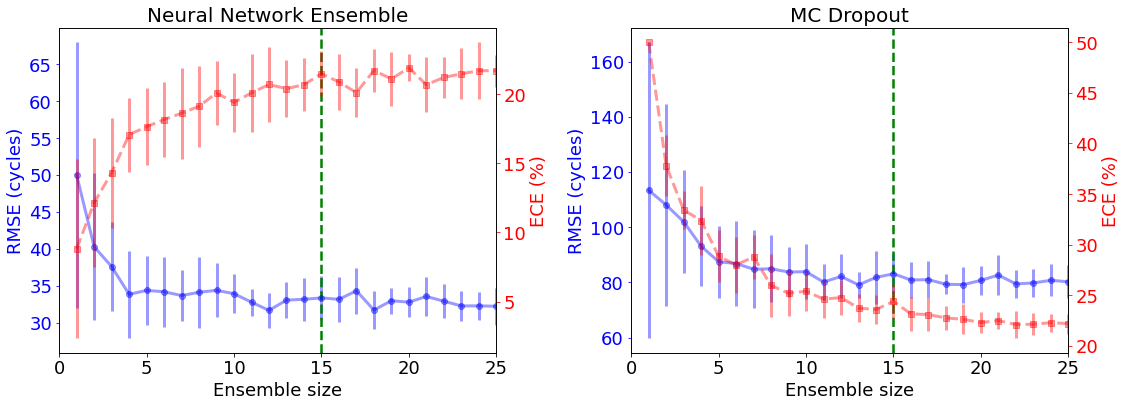

In [36]:
fig, ax = plt.subplots(1,2,figsize=(16, 6))
myax=ax[0]
myax.errorbar(range(1,max_ensemble+1), np.mean(global_rmse_NN, axis = 0), 
                 yerr = np.std(global_rmse_NN, axis = 0), linestyle='-',linewidth = 3,
                 fmt='o', color='blue', alpha = 0.4, label='RMSE')
myax.axvline(15, linestyle='--',color = 'green', linewidth = 2.5)
myax.set_xlabel('Ensemble size')
myax.set_ylabel('RMSE (cycles)')
myax.yaxis.label.set_color('blue')
myax.tick_params(axis='y', colors='blue')

myax=ax[0].twinx()
myax.errorbar(range(1,max_ensemble+1), np.mean(global_ece_NN, axis = 0), 
                 yerr = np.std(global_ece_NN, axis = 0), linestyle='--',linewidth = 3,
                 fmt='s', color='red', alpha = 0.4, label='ECE')
myax.yaxis.label.set_color('red')
myax.tick_params(axis='y', colors='red')
myax.set_ylabel('ECE (%)')
myax.set_title('Neural Network Ensemble', fontsize = 20)
myax.set_xlim([0,25])

myax=ax[1]
myax.errorbar(range(1,max_ensemble+1), np.mean(global_rmse_MC, axis = 0), 
                 yerr = np.std(global_rmse_MC, axis = 0), linestyle='-',linewidth = 3,
                 fmt='o', color='blue', alpha = 0.4, label='RMSE')
myax.axvline(15, linestyle='--',color = 'green', linewidth = 2.5)
myax.set_xlabel('Ensemble size')
myax.set_ylabel('RMSE (cycles)')
myax.yaxis.label.set_color('blue')
myax.tick_params(axis='y', colors='blue')

myax=ax[1].twinx()
myax.errorbar(range(1,max_ensemble+1), np.mean(global_ece_MC, axis = 0), 
                 yerr = np.std(global_ece_MC, axis = 0), linestyle='--', linewidth = 3,
                 fmt='s', color='red', alpha = 0.4, label='ECE')
myax.yaxis.label.set_color('red')
myax.tick_params(axis='y', colors='red')
myax.set_ylabel('ECE (%)')
myax.set_title('MC Dropout', fontsize = 20)
myax.set_xlim([0,25])
plt.tight_layout()
fig.savefig("figs/elbow_ensemble_combined.jpg")
fig.savefig("figs/elbow_ensemble_combined.pdf")

### Multiple independent runs to capture run-to-run variation

toggle `model_train_bool` to skip training and use saved results

In [37]:
model_train_bool = False
nmodels = 3 # total models trained and best one picked
nensemble_size = 15 # run these many times per each select model with dropout
niter = 10
if model_train_bool:


    allCI_MC = np.zeros((1000, niter))
    pbar=ProgressBar()
    allresults_MCdf = pd.DataFrame()

    for myiter in pbar(range(niter)): # for each independent iteration
        all_models_MC=[]
        all_rmse_train_MC = np.zeros(nmodels,)
        pbar = ProgressBar()
        for i in range(nmodels): # train multiple models to select the best
            model_MC = generate_trained_MCmodel(Xtrain_norm, Ytrain_norm, 10000, 'relu')
            all_rmse_train_MC[i] = get_rmse(K.get_value(model_MC(Xtrain_norm))*(np.max(Ytrain)), Ytrain)
            all_models_MC.append(model_MC)

        select_modelMC = all_models_MC[np.argmin(all_rmse_train_MC)] # best model

        for myset in dataset: # execute the model for all the datasets
            exec("Xnorm =X"+myset+"_norm")
            exec("Y =Y"+myset)

            result_df = pd.DataFrame(Y, columns = ['True'])
            result_df['dataset'] = myset
            for i in range(nensemble_size): # run the best model multiple times with dropout enabled
                result_df["MC_mu_"+str(i)] = K.get_value(select_modelMC(Xnorm, training=True))*(np.max(Ytrain))

            result_df['iteration'] = myiter
            allresults_MCdf = pd.concat([allresults_MCdf, result_df], axis = 0)
        allresults_MCdf = get_ensemble(allresults_MCdf, "MC", nensemble_size)
    allresults_MCdf.to_excel("MCDropout_battery_prediction_results.xlsx")  
else:
    allresults_MCdf=pd.read_excel("MCDropout_battery_prediction_results.xlsx")  

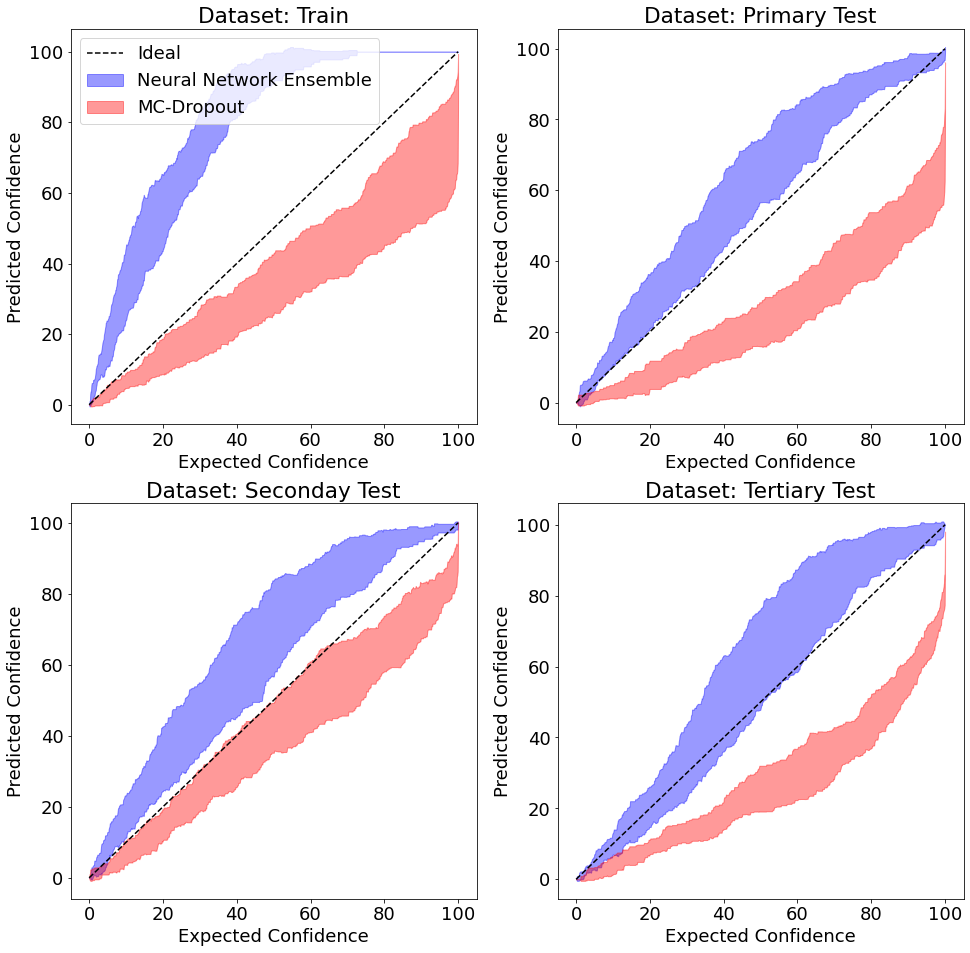

In [38]:
fig, ax = plt.subplots(2,2,figsize=(16, 16))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    
    allCI_NN = np.zeros((1000, niter))
    allCI_MC = np.zeros((1000, niter))
    for myiter in range(niter):
        # MC dropout
        df = allresults_MCdf.loc[(allresults_MCdf['dataset']==dataset[myset]) & 
                                 (allresults_MCdf['iteration']==myiter)]
        exp_CI, CI_MC, ECE = get_confidence_interval(df['True'].values, 
                                               df['MC_mu_eff'].values, 
                                               df['MC_sigma_eff'].values)
        allCI_MC[:,myiter] = CI_MC
        
        # Neural Network Ensemble
        df = allresults_NNdf.loc[(allresults_NNdf['dataset']==dataset[myset]) & 
                                 (allresults_NNdf['iteration']==myiter)]
        exp_CI, CI_NN, ECE = get_confidence_interval(df['True'].values, 
                                               df['NN_mu_eff'].values, 
                                               df['NN_sigma_eff'].values)
        allCI_NN[:,myiter] = CI_NN
        
        
    myax.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
    myax.fill_between(exp_CI,
                np.mean(allCI_NN, axis = 1)+np.std(allCI_NN, axis = 1),
                np.mean(allCI_NN, axis = 1)-np.std(allCI_NN, axis = 1),
                color='blue', alpha = 0.4, linestyle='None', label='Neural Network Ensemble')
    
    myax.fill_between(exp_CI,
                np.mean(allCI_MC, axis = 1)+np.std(allCI_MC, axis = 1),
                np.mean(allCI_MC, axis = 1)-np.std(allCI_MC, axis = 1),
                color='red', alpha = 0.4, linestyle='None', label='MC-Dropout')


    myax.set_title("Dataset: "+ title_dict[dataset[myset]])
    myax.set_xlabel("Expected Confidence")
    myax.set_ylabel("Predicted Confidence")
    if myset ==0:
        myax.legend()

## Uncertainty Model 3: Gaussian Process Regression (GP)

- use standard sklearn packages with RBF kernel

There is no run-to-run variation here (not considering noise component in GP)

In [39]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

model_GP = GaussianProcessRegressor(kernel=1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)), 
                                            n_restarts_optimizer=9)
model_GP.fit(Xtrain_norm, Ytrain_norm)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=9)

In [40]:
print("Train RMSE: ", get_rmse(model_GP.predict(Xtrain_norm, return_std=True)[0]*(np.max(Ytrain)), Ytrain))
print("Test1 RMSE: ", get_rmse(model_GP.predict(Xtest1_norm, return_std=True)[0]*(np.max(Ytrain)), Ytest1))
print("Test2 RMSE: ", get_rmse(model_GP.predict(Xtest2_norm, return_std=True)[0]*(np.max(Ytrain)), Ytest2))
print("Test3 RMSE: ", get_rmse(model_GP.predict(Xtest3_norm, return_std=True)[0]*(np.max(Ytrain)), Ytest3))

Train RMSE:  6.6646218447636414e-06
Test1 RMSE:  141.13308396167866
Test2 RMSE:  319.00523478102014
Test3 RMSE:  406.485993597908


In [41]:
model_train_bool = False
if model_train_bool:
    allresults_GPdf = pd.DataFrame()
    for myset in dataset:
        exec("Xnorm =X"+myset+"_norm")
        exec("Y =Y"+myset)

        result_df = pd.DataFrame(Y, columns = ['True'])
        result_df['dataset'] = myset
        result_df["GP_mu_eff"], result_df["GP_sigma_eff"] = model_GP.predict(Xnorm, return_std=True)
        allresults_GPdf = pd.concat([allresults_GPdf, result_df], axis = 0)

    allresults_GPdf["GP_mu_eff"] = allresults_GPdf["GP_mu_eff"]*(np.max(Ytrain))
    allresults_GPdf["GP_sigma_eff"] = allresults_GPdf["GP_sigma_eff"]*(np.max(Ytrain))
    allresults_GPdf.to_excel("GPR_battery_prediction_results.xlsx")
else:
    allresults_GPdf=pd.read_excel("GPR_battery_prediction_results.xlsx")

In [42]:
allresults_GPdf.head()

,Unnamed: 0,True,dataset,GP_mu_eff,GP_sigma_eff
0,0,2160,train,2159.999995,0.0216
1,1,1434,train,1433.999996,0.0216
2,2,1074,train,1074.000009,0.0216
3,3,870,train,869.999991,0.0216
4,4,788,train,788.000011,0.0216


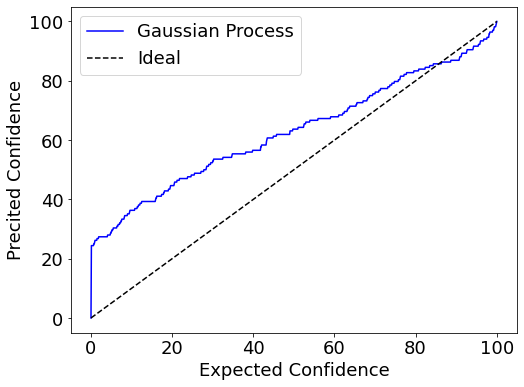

In [43]:
exp_CI, CI_GP, ECE = get_confidence_interval(allresults_GPdf['True'].values, 
                                       allresults_GPdf['GP_mu_eff'].values, 
                                       allresults_GPdf['GP_sigma_eff'].values)
fig = plt.figure(figsize=(8,6))
plt.plot(exp_CI,CI_GP, color = 'blue', label='Gaussian Process')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()

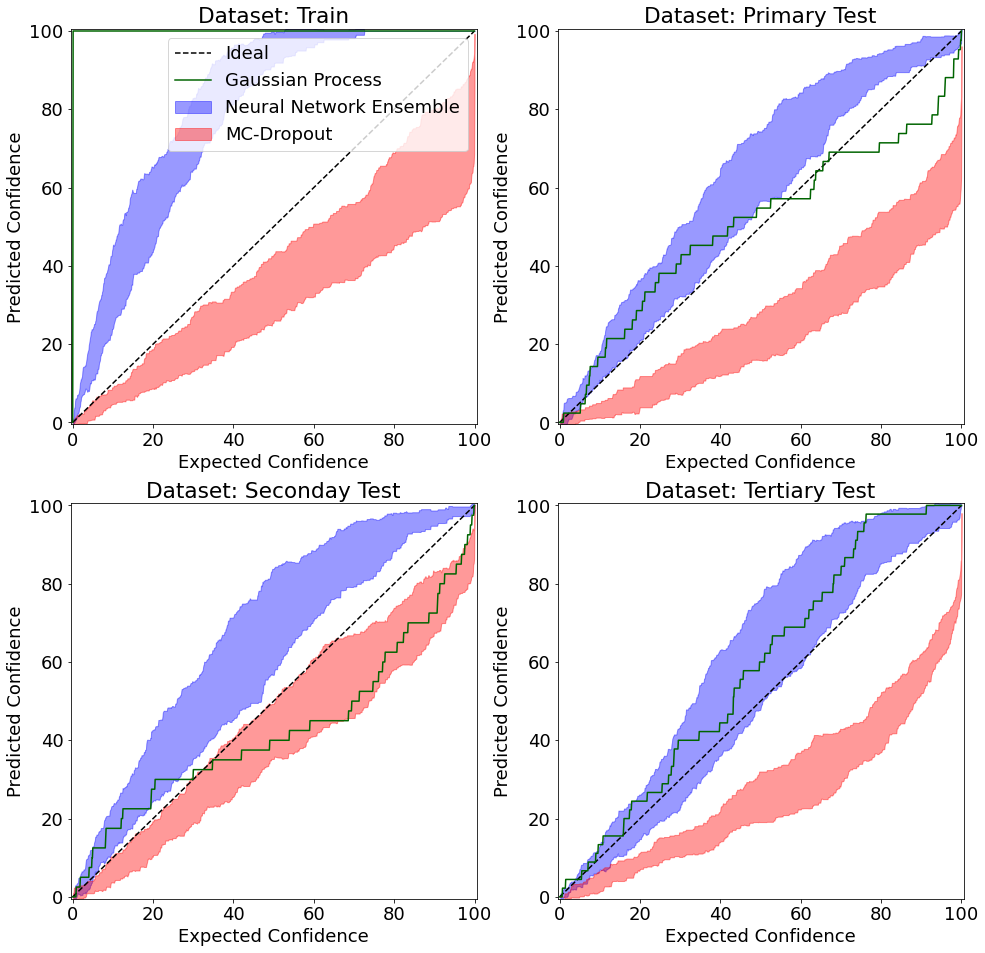

In [44]:
# plot GPR - there is no run to run variation here. 
fig, ax = plt.subplots(2,2,figsize=(16, 16))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    df = allresults_GPdf.loc[allresults_GPdf['dataset']==dataset[myset]]
    
    exp_CI, CI_GP, ECE = get_confidence_interval(df['True'].values, 
                                           df['GP_mu_eff'].values, 
                                           df['GP_sigma_eff'].values)
    
    myax.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
    myax.plot(exp_CI,CI_GP, color = 'darkgreen', label='Gaussian Process')
    

    myax.set_title("Dataset: "+ dataset[myset])
    myax.set_xlabel("Expected Confidence")
    myax.set_ylabel("Predicted Confidence")
    if myset ==0:
        myax.legend()

# plotting DE and MC
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    
    allCI_NN = np.zeros((1000, niter))
    allCI_MC = np.zeros((1000, niter))
    for myiter in range(niter):
        df = allresults_MCdf.loc[(allresults_MCdf['dataset']==dataset[myset]) & 
                                 (allresults_MCdf['iteration']==myiter)]
        exp_CI, CI_MC, ECE = get_confidence_interval(df['True'].values, 
                                               df['MC_mu_eff'].values, 
                                               df['MC_sigma_eff'].values)
        allCI_MC[:,myiter] = CI_MC
        
        df = allresults_NNdf.loc[(allresults_NNdf['dataset']==dataset[myset]) & 
                                 (allresults_NNdf['iteration']==myiter)]
        exp_CI, CI_NN, ECE = get_confidence_interval(df['True'].values, 
                                               df['NN_mu_eff'].values, 
                                               df['NN_sigma_eff'].values)
        allCI_NN[:,myiter] = CI_NN
        
        
    myax.fill_between(exp_CI,
                np.mean(allCI_NN, axis = 1)+np.std(allCI_NN, axis = 1),
                np.mean(allCI_NN, axis = 1)-np.std(allCI_NN, axis = 1),
                color='blue', alpha = 0.4, linestyle='None', label='Neural Network Ensemble')
    
    myax.fill_between(exp_CI,
                np.mean(allCI_MC, axis = 1)+np.std(allCI_MC, axis = 1),
                np.mean(allCI_MC, axis = 1)-np.std(allCI_MC, axis = 1),
                color='red', alpha = 0.4, linestyle='None', label='MC-Dropout')


    myax.set_title("Dataset: "+ title_dict[dataset[myset]])
    myax.set_xlabel("Expected Confidence")
    myax.set_ylabel("Predicted Confidence")
    myax.set_xlim([-0.5, 100.5])
    myax.set_ylim([-0.5, 100.5])
    if myset ==0:
        myax.legend()

## SNGP

distance-aware based

 - spectral normalization from keras layers
 - gaussian process from gpflow, gpflux libraries

(inspiration from https://secondmind-labs.github.io/GPflux/notebooks/gpflux_with_keras_layers.html and https://www.tensorflow.org/tutorials/understanding/sngp)

#### Note: Please run `UQ_models_train_evaluate_FinalSNGP` notebook for SNGP

In [45]:
allresults_SNGPdf=pd.read_excel("SNGP_battery_prediction_results.xlsx")  

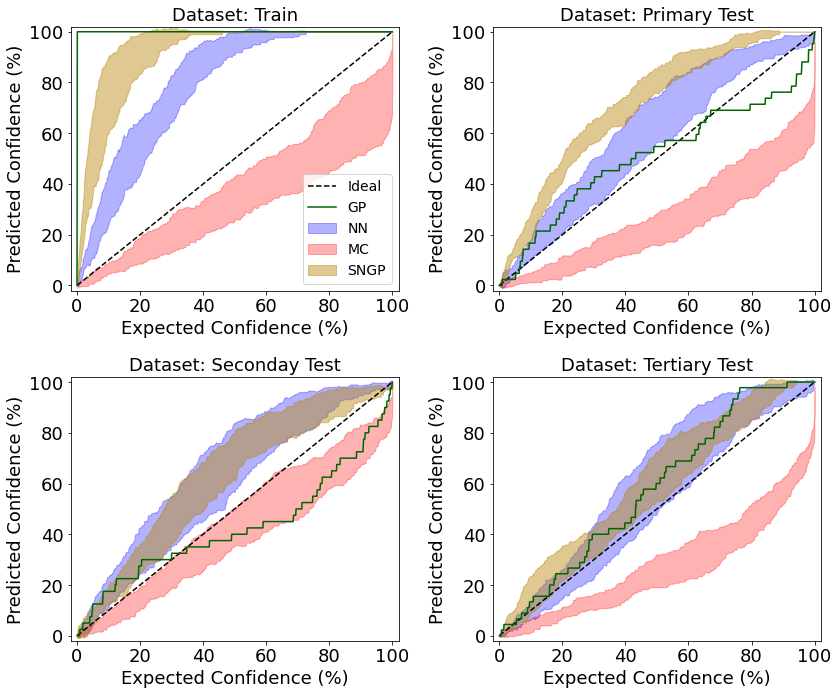

In [46]:
fig, ax = plt.subplots(2,2,figsize=(12, 10))

# plot GPR - there is no run to run variation here. 
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    df = allresults_GPdf.loc[allresults_GPdf['dataset']==dataset[myset]]
    
    exp_CI, CI_GP, ECE = get_confidence_interval(df['True'].values, 
                                           df['GP_mu_eff'].values, 
                                           df['GP_sigma_eff'].values)
    
    myax.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
    myax.plot(exp_CI,CI_GP, color = 'darkgreen', label='GP')


# plotting SNGP, DE and MC
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    
    allCI_NN = np.zeros((1000, niter))
    allCI_MC = np.zeros((1000, niter))
    allCI_SNGP = np.zeros((1000, niter))
    for myiter in range(niter):
        df = allresults_MCdf.loc[(allresults_MCdf['dataset']==dataset[myset]) & 
                                 (allresults_MCdf['iteration']==myiter)]
        exp_CI, CI_MC, ECE = get_confidence_interval(df['True'].values, 
                                               df['MC_mu_eff'].values, 
                                               df['MC_sigma_eff'].values)
        allCI_MC[:,myiter] = CI_MC
        
        df = allresults_NNdf.loc[(allresults_NNdf['dataset']==dataset[myset]) & 
                                 (allresults_NNdf['iteration']==myiter)]
        exp_CI, CI_NN, ECE = get_confidence_interval(df['True'].values, 
                                               df['NN_mu_eff'].values, 
                                               df['NN_sigma_eff'].values)
        allCI_NN[:,myiter] = CI_NN
        
        df = allresults_SNGPdf.loc[(allresults_SNGPdf['dataset']==dataset[myset]) & 
                                 (allresults_SNGPdf['iteration']==myiter)]
        exp_CI, CI_SNGP, ECE = get_confidence_interval(df['True'].values, 
                                               df['SNGP_mu_eff'].values, 
                                               df['SNGP_sigma_eff'].values)
        allCI_SNGP[:,myiter] = CI_SNGP
    
    myax.fill_between(exp_CI,
                np.mean(allCI_NN, axis = 1)+np.std(allCI_NN, axis = 1),
                np.mean(allCI_NN, axis = 1)-np.std(allCI_NN, axis = 1),
                color='blue', alpha = 0.3, linestyle='None', label='NN')
    
    myax.fill_between(exp_CI,
                np.mean(allCI_MC, axis = 1)+np.std(allCI_MC, axis = 1),
                np.mean(allCI_MC, axis = 1)-np.std(allCI_MC, axis = 1),
                color='red', alpha = 0.3, linestyle='None', label='MC')
    
    myax.fill_between(exp_CI,
                np.mean(allCI_SNGP, axis = 1)+np.std(allCI_SNGP, axis = 1),
                np.mean(allCI_SNGP, axis = 1)-np.std(allCI_SNGP, axis = 1),
                color='darkgoldenrod', alpha = 0.45, linestyle='None', label='SNGP')

    myax.set_title("Dataset: "+ title_dict[dataset[myset]], fontsize = 18)
    myax.set_xlabel("Expected Confidence (%)")
    myax.set_ylabel("Predicted Confidence (%)")
    myax.set_xlim([-2,102])
    myax.set_ylim([-2,102])
    if myset == 0:
        myax.legend(loc = 'lower right', fontsize=14)
#         myax.legend(loc='upper center', bbox_to_anchor=(1.0, -1.45), ncol=3, fancybox=True)

plt.tight_layout()
fig.savefig("figs/calibration_curves.jpg")
fig.savefig("figs/calibration_curves.pdf")

## Step 3: Postprocess UQ model results

- we already showed calibration curve above
- compile RMSE, NLL and ECE for all models
- some plots in the paper

In [47]:
def get_error_metrics(pred_df, UQmodelcode):
    dataset = ['train', 'test1', 'test2', 'test3']
    if UQmodelcode == 'GP':
        niters = {0}
    else:
        niters = set(pred_df['iteration'])
    
    results_df = pd.DataFrame()
    results_df['dataset'] = dataset
    
    allrmse, allnll, allece = [], [], []
    for myset in dataset:
        myrmse, mynll, myece = np.zeros(len(niters),), np.zeros(len(niters),), np.zeros(len(niters),)
        for myiter in niters:
            if UQmodelcode == 'GP':
                df = pred_df.loc[(pred_df['dataset']==myset)]
            else:
                df = pred_df.loc[(pred_df['dataset']==myset) & (pred_df['iteration']==myiter)]
            myrmse[myiter] = get_rmse(df['True'], df[UQmodelcode+'_mu_eff'])
            mynll[myiter]  = get_nll(df['True'], df[UQmodelcode+'_mu_eff'], 
                                     df[UQmodelcode+'_sigma_eff'])
            exp_CI, CI_MC, myece[myiter] = get_confidence_interval(df['True'].values, 
                                             df[UQmodelcode+'_mu_eff'].values, 
                                             df[UQmodelcode+'_sigma_eff'].values)
            
        allrmse.append(myrmse)
        allnll.append(mynll)
        allece.append(myece)
    
    results_df['rmse_mean'] = np.mean(allrmse,axis = 1)
    results_df['rmse_std']  = np.std(allrmse,axis = 1)
    
    results_df['nll_mean'] = np.mean(allnll,axis = 1)
    results_df['nll_std']  = np.std(allnll,axis = 1)
    
    results_df['ece_mean'] = np.mean(allece,axis = 1)
    results_df['ece_std']  = np.std(allece,axis = 1)
    results_df = results_df.round(2)
    
    results_df['rmse']=results_df['rmse_mean'].astype(str) + "±" + results_df['rmse_std'].astype(str)
    results_df['nll'] =results_df['nll_mean'].astype(str) + "±" + results_df['nll_std'].astype(str)
    results_df['ece'] =results_df['ece_mean'].astype(str) + "±" + results_df['ece_std'].astype(str)

    return results_df

In [48]:
## Display error metrics for all the models
df = get_error_metrics(allresults_NNdf,'NN')
display('Neural Network Ensemble',df[['dataset', 'rmse', 'nll', 'ece']])

df = get_error_metrics(allresults_MCdf,'MC')
display('MC Dropout',df[['dataset', 'rmse', 'nll', 'ece']])

df = get_error_metrics(allresults_GPdf,'GP')
display('Gaussian Process',df[['dataset', 'rmse', 'nll', 'ece']])

df = get_error_metrics(allresults_SNGPdf,'SNGP')
display('SNGP',df[['dataset', 'rmse', 'nll', 'ece']])

'Neural Network Ensemble'

,dataset,rmse,nll,ece
0,train,68.13±22.09,4.73±0.33,29.82±3.69
1,test1,137.28±20.89,5.41±0.22,10.48±4.97
2,test2,205.08±27.4,5.72±0.17,13.53±5.7
3,test3,183.88±46.87,5.65±0.13,9.79±4.53


'MC Dropout'

,dataset,rmse,nll,ece
0,train,69.35±16.82,8.56±2.59,15.22±6.79
1,test1,149.86±18.35,14.29±6.52,24.35±5.33
2,test2,194.14±15.07,6.87±1.29,9.54±4.58
3,test3,195.01±29.08,9.15±1.73,22.56±3.43


'Gaussian Process'

,dataset,rmse,nll,ece
0,train,0.0±0.0,-3.84±0.0,49.9±0.0
1,test1,141.13±0.0,5.71±0.0,6.95±0.0
2,test2,319.01±0.0,6.01±0.0,10.4±0.0
3,test3,406.49±0.0,6.4±0.0,7.99±0.0


'SNGP'

,dataset,rmse,nll,ece
0,train,34.78±14.67,5.61±0.02,42.48±3.01
1,test1,148.12±16.23,5.74±0.02,21.46±2.29
2,test2,249.26±33.64,6.12±0.14,12.68±4.57
3,test3,258.92±60.63,5.95±0.11,9.31±4.42


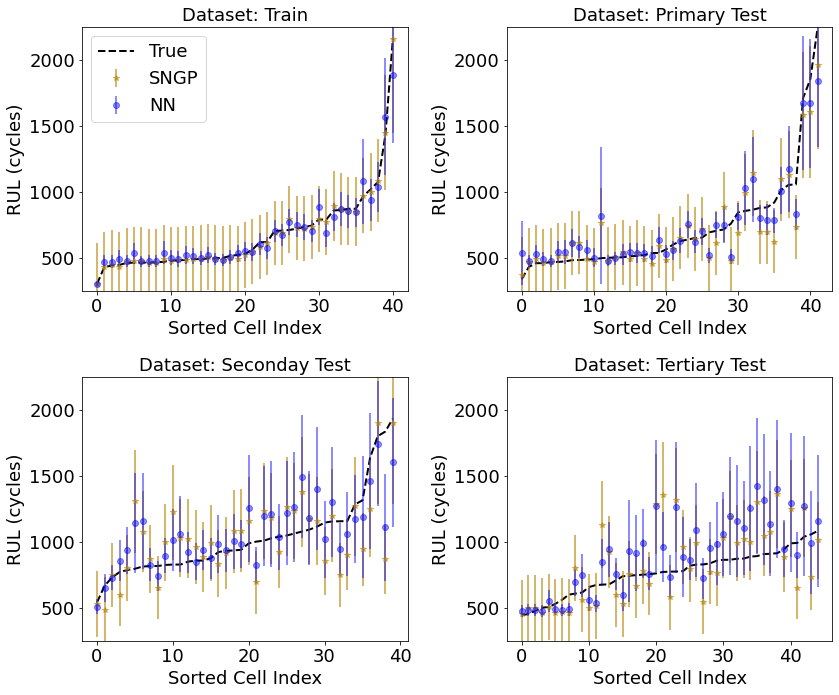

In [49]:
myiter = 3 # pick any one of 10 iterations
allresults_NNdf_sorted = allresults_NNdf.loc[allresults_NNdf['iteration']==myiter].sort_values(by='True', ascending=True)
allresults_MCdf_sorted = allresults_MCdf.loc[allresults_MCdf['iteration']==myiter].sort_values(by='True', ascending=True)
allresults_SNGPdf_sorted = allresults_SNGPdf.loc[allresults_SNGPdf['iteration']==myiter].sort_values(by='True', ascending=True)
allresults_GPdf_sorted = allresults_GPdf.sort_values(by='True', ascending=True)

fig, ax = plt.subplots(2,2,figsize=(12, 10))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    # True
    df = allresults_NNdf_sorted.loc[allresults_NNdf_sorted['dataset']==dataset[myset]]
    myax.plot(range(df.shape[0]), df['True'], 
             color='black', linestyle='dashed', linewidth=2, label='True')
    # SNGP
    df = allresults_SNGPdf_sorted.loc[allresults_SNGPdf_sorted['dataset']==dataset[myset]]
    myax.errorbar(range(df.shape[0]), df['SNGP_mu_eff'], 
                 yerr = df['SNGP_sigma_eff'],
                 fmt='*', color='darkgoldenrod', alpha = 0.6, elinewidth=2 , label='SNGP')
    # NN
    df = allresults_NNdf_sorted.loc[allresults_NNdf_sorted['dataset']==dataset[myset]]
    myax.errorbar(range(df.shape[0]), df['NN_mu_eff'], 
                 yerr = df['NN_sigma_eff'],
                 fmt='o', color='blue', alpha = 0.45, elinewidth=2 , label='NN')
    # MC
#     df = allresults_MCdf_sorted.loc[allresults_MCdf_sorted['dataset']==dataset[myset]]
#     myax.errorbar(range(df.shape[0]), df['MC_mu_eff'], 
#                  yerr = df['MC_sigma_eff'],
#                  fmt='s', color='red', alpha = 0.45, elinewidth=2, label='MC Dropout')
    
    # GP
#     df = allresults_GPdf_sorted.loc[allresults_GPdf_sorted['dataset']==dataset[myset]]
#     myax.errorbar(range(df.shape[0]), df['GP_mu_eff'], 
#                  yerr = df['GP_sigma_eff'],markersize = 10,
#                  fmt='*', color='darkgreen', alpha = 0.6, label='Gaussian process')
    
    
    myax.set_title("Dataset: "+ title_dict[dataset[myset]], fontsize=18)
    myax.set_xlabel("Sorted Cell Index")
    myax.set_ylabel("RUL (cycles)")
    myax.set_ylim([250, 2250])
    if myset ==0:
        myax.legend()
plt.tight_layout()
fig.savefig("figs/ascending_errors.jpg")
fig.savefig("figs/ascending_errors.pdf")